# Examining Clustering Methods Outside of Original Model Pipeline

Recall, the first yield curve model we used was comprised of PCA reduction to 2 dimensions, followed by K-Means Clustering with $k=4$. In this experiment we are going to look at other pipelines or methods to cluster the yield curve. Our goal is to see some sort of higher fluctuation in regime changes. For reference, see the figure below. The labels are color coded at the bottom and we can see from around 2009-2017, we stay in the same regime. We don't think this is accurate.

![alternative text](../Figures/yc_labels_monthly.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from fredapi import Fred
import quandl as q
fred = Fred(api_key="11ae3d2ef9363b6c65ce74df68755758")
plt.style.use("ggplot")

## Data

Let's begin with just the synthetic yield curve. From summary statistics we can infer that we don't need to use the capped rates (the ones that dropped based on a ceiling), because the descriptive stats look pretty clean.

In [2]:
# Read in the monthly synthetic yield curve
yc = pd.read_csv("../Data/monthly_ns_yields.csv")

# Daily available to try too
# yc = pd.read_csv("../Data/daily_ns_yields_ceil.csv")

yc["Date"] = pd.to_datetime(yc["Date"])
yc.set_index("Date", inplace=True)
display(yc.describe())
display(yc.head())

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,2.556170,2.583785,2.610495,2.687006,2.831701,3.103054,3.347191,3.739967,4.019500,4.292741,4.669023,4.799686
std,2.268561,2.277483,2.286125,2.308293,2.333934,2.333504,2.298362,2.203517,2.120855,2.036569,1.930509,1.900817
min,-0.083759,-0.055278,-0.026368,-0.000703,0.003392,0.017112,0.081125,0.273081,0.457386,0.664531,0.974106,1.083449
25%,0.176054,0.180174,0.179131,0.244958,0.435696,0.808063,1.182944,1.745623,2.097975,2.479901,2.894434,3.036104
50%,2.067047,2.059395,2.051360,2.053904,2.358716,2.651985,2.906152,3.400301,3.863933,4.228219,4.674191,4.772423
75%,4.830328,4.852841,4.880363,4.930068,4.923898,5.143153,5.343597,5.612356,5.790107,5.896628,6.076598,6.091548
max,8.094605,8.149061,8.200974,8.342540,8.570540,8.863750,9.017706,9.121306,9.118693,9.073159,8.990934,9.049977


,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-01,7.994548,8.011124,8.027052,8.071205,8.145211,8.249796,8.315405,8.383563,8.412346,8.429399,8.442435,8.446022
1990-02-01,7.999678,8.022912,8.045166,8.106453,8.207571,8.345454,8.426767,8.501494,8.525032,8.531369,8.524469,8.520694
1990-03-01,8.048065,8.084310,8.118849,8.212956,8.364200,8.557658,8.658054,8.722952,8.717938,8.684207,8.610935,8.583186
1990-04-01,8.094605,8.149061,8.200974,8.342540,8.570540,8.863750,9.017706,9.121306,9.118693,9.073159,8.970445,8.931332
1990-05-01,7.961352,7.993744,8.024691,8.109460,8.247509,8.429996,8.531443,8.612346,8.626360,8.615545,8.577763,8.562651


## K-Means 

Starting back at square one, we can try K-Means with no PCA and see how it looks. Following the same procedure to verify number of clusters, then fit, visualize shapes, and labels over time.

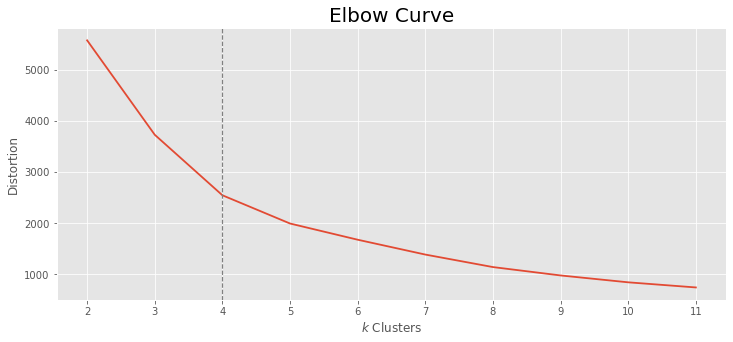

In [3]:
distortions = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(yc)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(12, 5))
plt.plot(range(2, 12), distortions, linewidth=1.8)
plt.grid(True)
plt.title('Elbow Curve', fontsize=20)
plt.xticks(np.arange(2,12,1))
plt.axvline(x=4, linewidth=1.2, linestyle="--", color="grey")
plt.xlabel(r"$k$ Clusters")
plt.ylabel("Distortion")
plt.show()

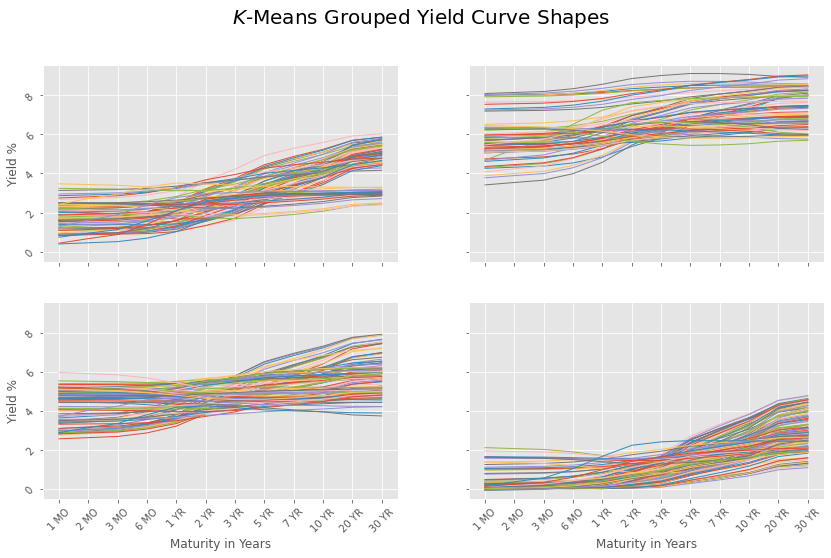

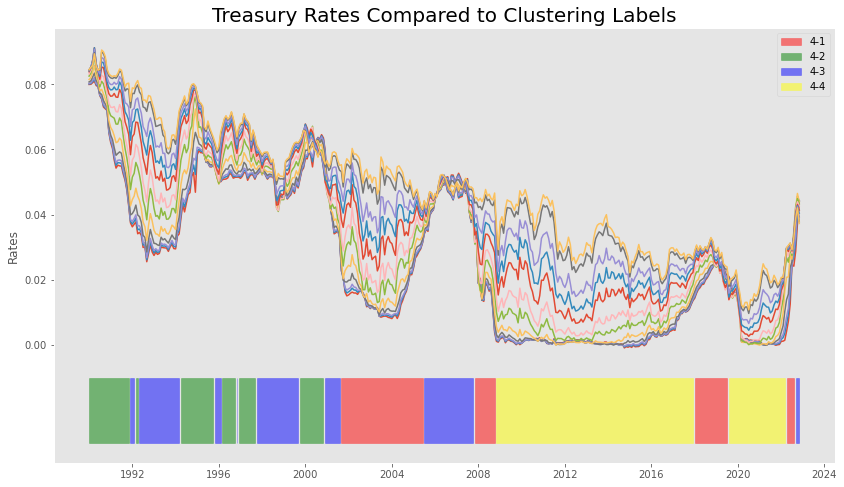

In [50]:
kmeans = KMeans(n_clusters=4).fit(yc)

labeled = yc.copy()
# labeled["Mean"] = labeled.mean(axis=1)
labeled.loc[:,"Label"] = kmeans.predict(yc)
# labeled = labeled[["Mean", "Label"]]
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'$K$-Means Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

In [47]:
labeled.mean(axis=1)

Date
1990-01-01    7.686778
1990-02-01    7.750543
1990-03-01    7.874101
1990-04-01    8.111855
1990-05-01    7.791758
                ...   
2022-07-01    2.522308
2022-08-01    2.946923
2022-09-01    3.730000
2022-10-01    4.180769
2022-11-01    4.099231
Length: 395, dtype: float64

The labels don't seem to get better here. K-Means might be out.

## Affinity Propagation

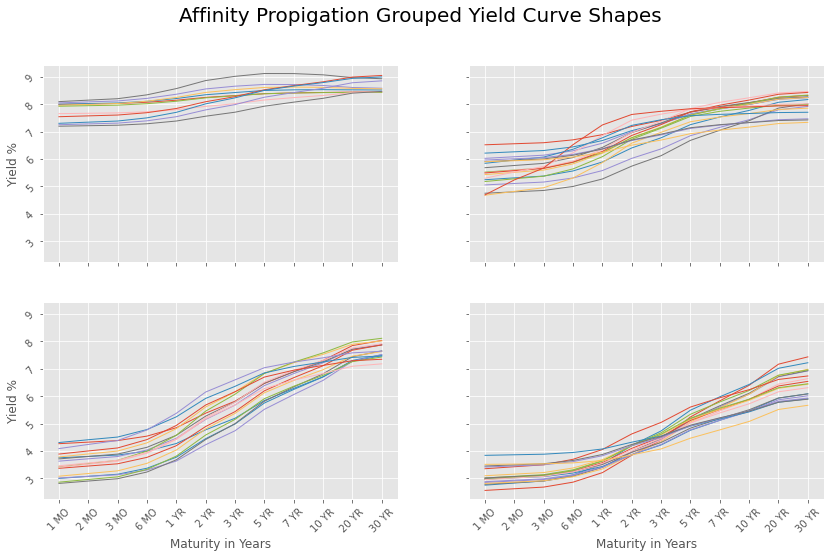

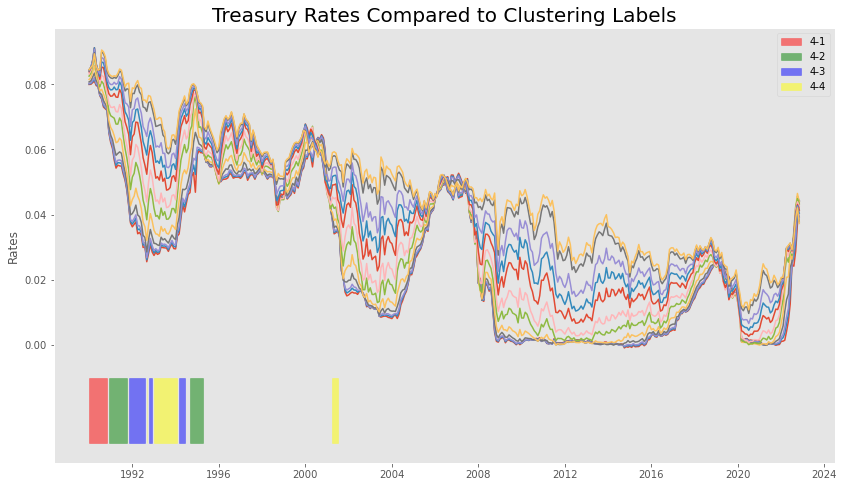

In [5]:
from sklearn.cluster import AffinityPropagation

afprop = AffinityPropagation().fit(yc)

labeled = yc.copy()
labeled.loc[:,"Label"] = afprop.predict(yc)
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'Affinity Propigation Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

Looks a little different, since we are "missing" some labels, let's look deeper.

In [6]:
labeled["Label"].value_counts()

4     54
10    50
9     44
8     38
6     30
13    30
5     21
12    21
11    21
7     20
1     19
3     19
2     17
0     11
Name: Label, dtype: int64

We get more labels with this method (out of scope). We can visualize these here.

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=labeled.index, y=labeled["Label"], name="Affinity Prop"))

fig.update_layout(title=f"Affinity Propigation Generated Labels: Suggested Number = {len(afprop.cluster_centers_indices_)}")

fig.show()

We can change some parameters in the algorithm to try to reduce the number of clusters. This prints a bunch of messy output, but basically after preference parameter gets lower than -600, we tend to 4 clusters. Use ```random_state``` to lock that in for replication.

In [8]:
# for i in range(1000):
#     afprop = AffinityPropagation(preference=-i).fit(yc)
#     n_clusters = len(afprop.cluster_centers_indices_)
#     print(f"Preference: {-i}, Number of Clusters: {n_clusters}")

afprop = AffinityPropagation(preference=-600, random_state=1).fit(yc)
n_clusters = len(afprop.cluster_centers_indices_)
print(f"Number of Clusters: {n_clusters}")

Number of Clusters: 4


Number of Clusters: 4


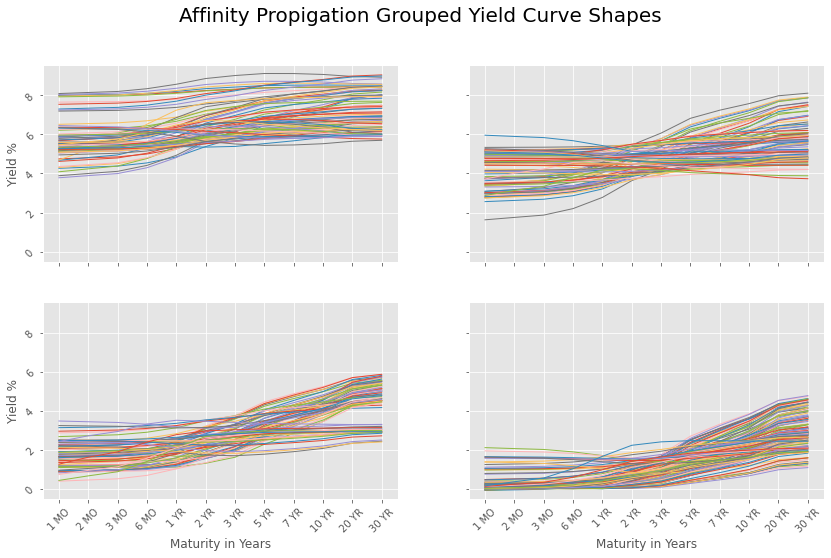

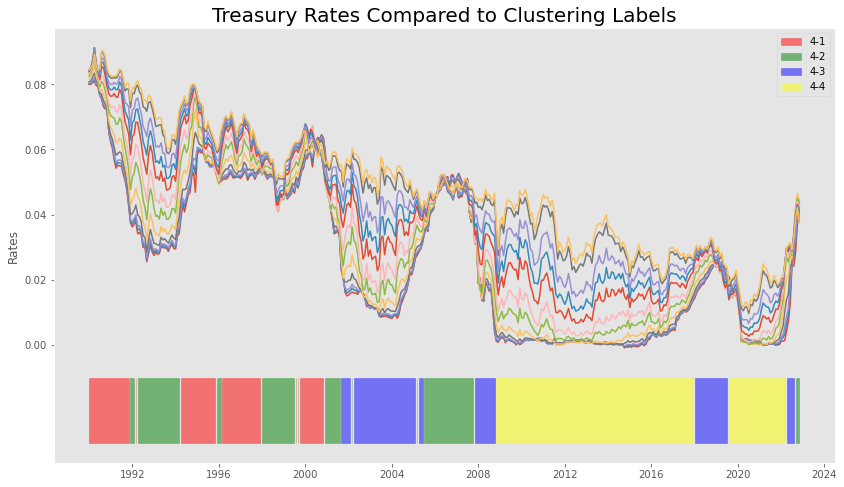

In [9]:
afprop = AffinityPropagation(preference=-600, random_state=1).fit(yc)
n_clusters = len(afprop.cluster_centers_indices_)
print(f"Number of Clusters: {n_clusters}")

labeled = yc.copy()
labeled.loc[:,"Label"] = afprop.predict(yc)
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'Affinity Propigation Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

In [10]:
print(f"Number of Data Points: {len(labeled)}")
print(f'Value Counts:\n{labeled["Label"].value_counts()}')
print(f'Number of Labels: {labeled["Label"].value_counts().sum()}')
print(f'Number of Data Points == Number of Labels: {len(labeled) == labeled["Label"].value_counts().sum()}')

Number of Data Points: 395
Value Counts:
3    142
1     92
0     81
2     80
Name: Label, dtype: int64
Number of Labels: 395
Number of Data Points == Number of Labels: True


This looks a little better. We get some more fluxuations in regime changes but still have that large span in the same time frame of 2009-2017ish that persists.

## Agglomeratuve Clustering

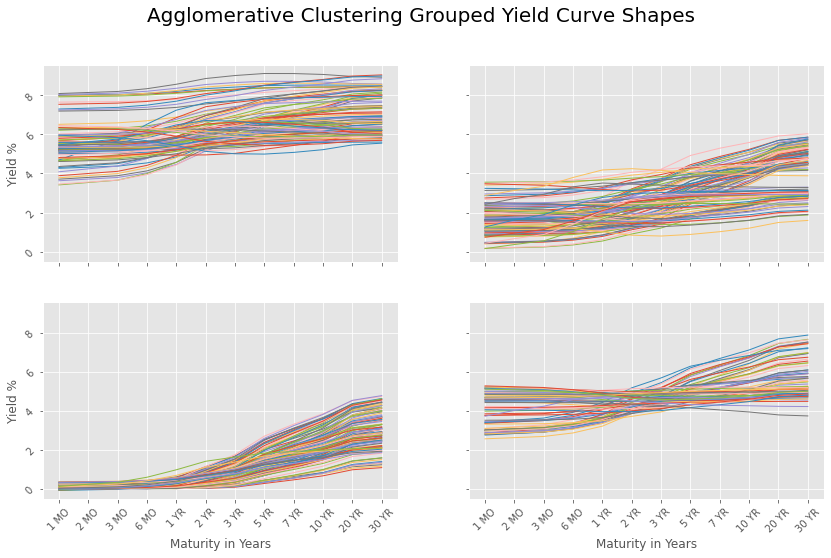

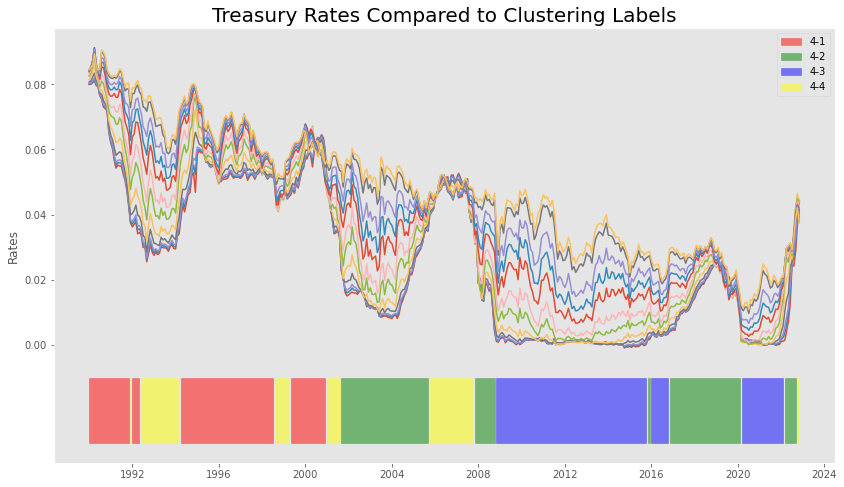

In [11]:
from sklearn.cluster import AgglomerativeClustering

agclust = AgglomerativeClustering(n_clusters=4).fit(yc)

labeled = yc.copy()
# labeled.loc[:,"Label"] = agclust.predict(yc)
labeled.loc[:,"Label"] = agclust.labels_
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'Agglomerative Clustering Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

This method probably wont work for us. It uses the inherent structure in the data to form clusters and doesn't "train" a model per se. We would ahve a problem when we go to test out of sample, we can't use the Agglomerative Cluster model to predict on its own, it only has a ```fit_predict()``` method.

## BIRCH

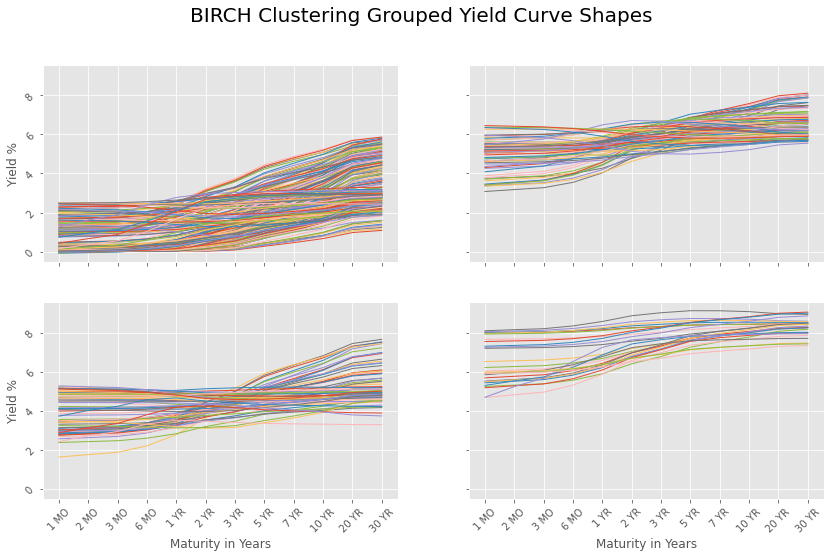

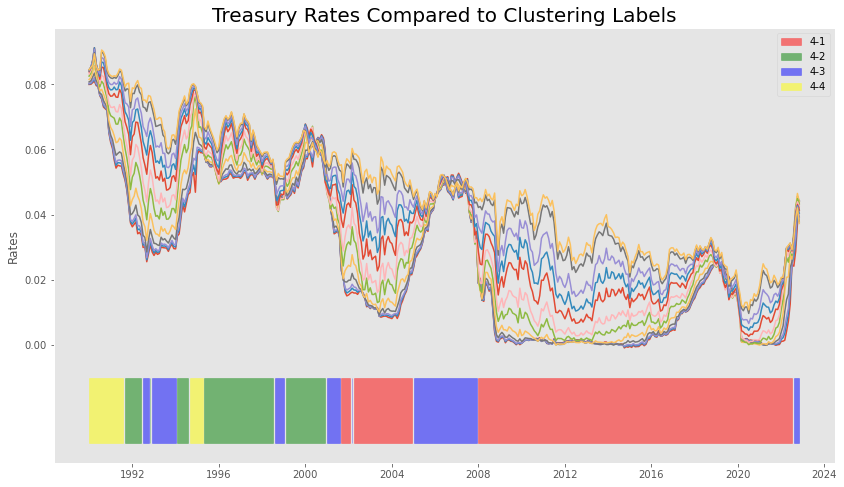

In [12]:
from sklearn.cluster import Birch

brch = Birch(n_clusters=4).fit(yc)

labeled = yc.copy()
labeled.loc[:,"Label"] = brch.predict(yc)
# labeled.loc[:,"Label"] = agclust.labels_
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'BIRCH Clustering Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

## DBSCAN

Number of Labels: 6
Labels: [-1  0  1  2  3  4]


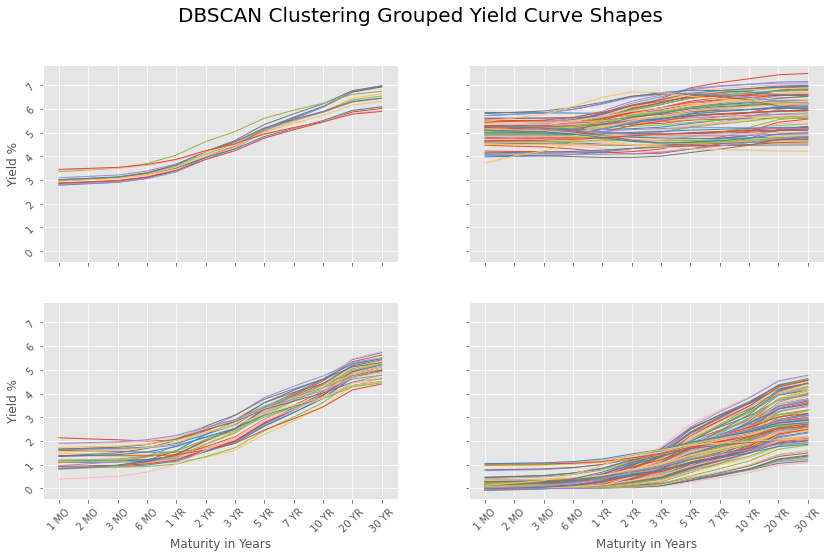

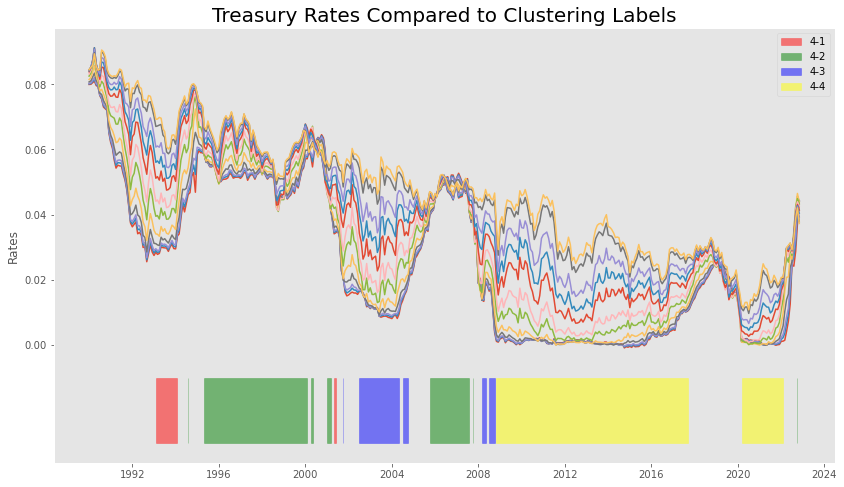

In [13]:
from sklearn.cluster import DBSCAN

# dbsc = DBSCAN(min_samples=10).fit(yc)
dbsc = DBSCAN(eps=1.3, min_samples=15).fit(yc)

labeled = yc.copy()
# labeled.loc[:,"Label"] = dbsc.predict(yc)
labeled.loc[:,"Label"] = dbsc.labels_

n_labels = len(np.unique(dbsc.labels_))
print(f"Number of Labels: {n_labels}")
print(f"Labels: {np.unique(dbsc.labels_)}")

g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'DBSCAN Clustering Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

We don't want labels of -1, that means a noisy sample. We might be able to optimize this one to get 4 labels, but we can see that pervasiveness again so not worth the time right now.

## Gaussian Mixture

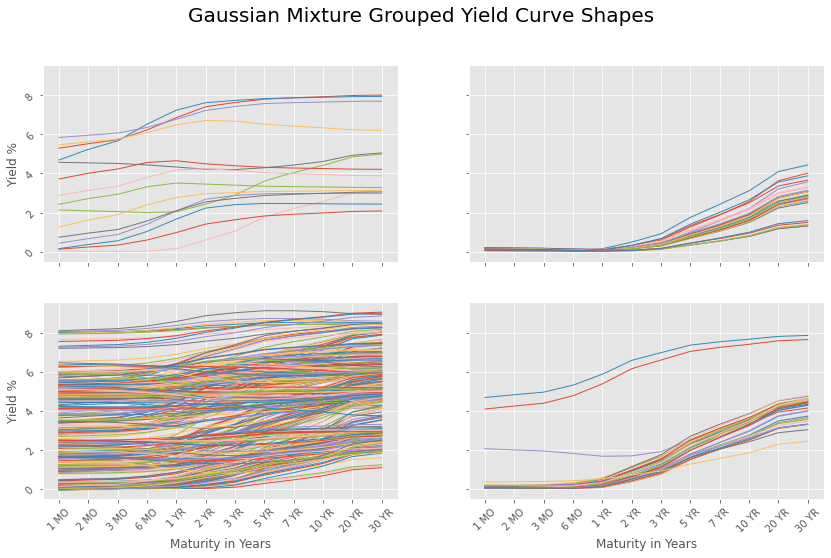

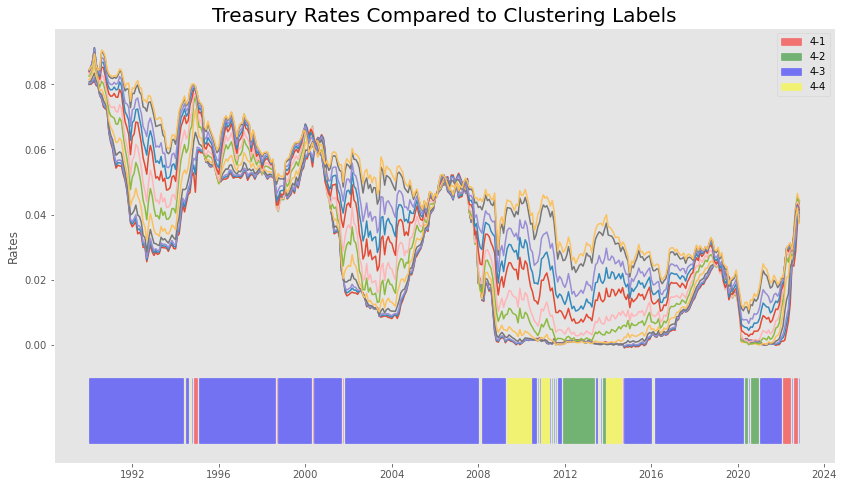

In [21]:
from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=4).fit(yc)
# gmm = GaussianMixture(n_components=4, init_params='k-means++').fit(yc)
# gmm = GaussianMixture(n_components=4, init_params='random').fit(yc)
gmm = GaussianMixture(n_components=4, init_params='random_from_data').fit(yc)

labeled = yc.copy()
labeled.loc[:,"Label"] = gmm.predict(yc)
# labeled.loc[:,"Label"] = agclust.labels_
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'Gaussian Mixture Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

## Mean Shift

Bandwith: 3.5, Clusters: 5


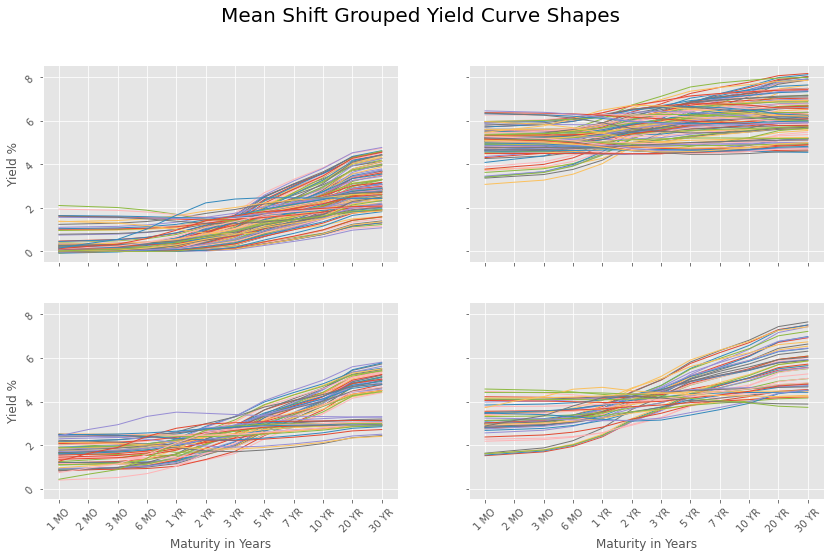

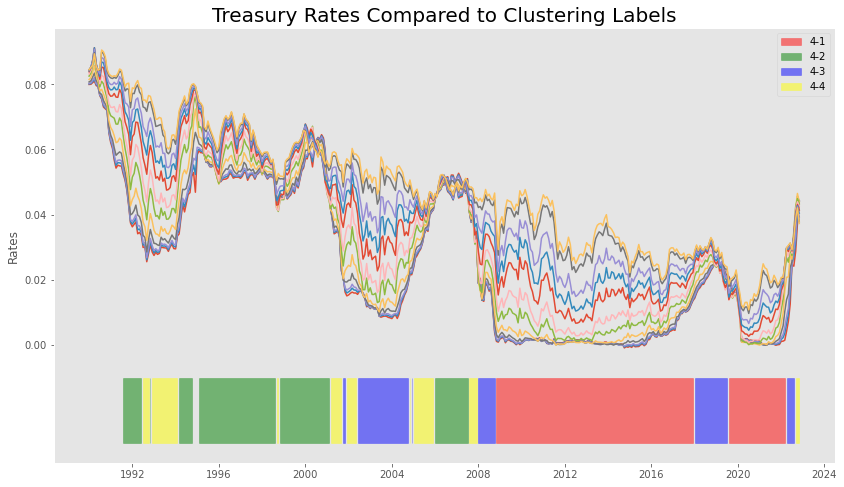

In [42]:
from sklearn.cluster import MeanShift

meanshift = MeanShift(bandwidth=3.5).fit(yc)
n_clusters = len(meanshift.cluster_centers_)
print(f"Bandwith: {meanshift.bandwidth}, Clusters: {n_clusters}")

labeled = yc.copy()
labeled.loc[:,"Label"] = meanshift.predict(yc)
# labeled.loc[:,"Label"] = agclust.labels_
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'Mean Shift Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

We need to optimize the bandwidth here.

In [41]:
bws = []
for i in np.linspace(0, 5, 100):
    if i <= 0:
        pass
    else:
        meanshift = MeanShift(bandwidth=i, n_jobs=-1).fit(yc)
        n_clusters = len(meanshift.cluster_centers_)
        # print(f"Bandwith: {meanshift.bandwidth}, Clusters: {n_clusters}")
        if n_clusters == 4:
            bws.append(i)
print("Bandwithds that give 4 clusters:\n", bws)

Bandwithds that give 4 clusters:
 [3.5858585858585856, 3.6363636363636362, 3.8383838383838382, 3.888888888888889]


Bandwith: 3.5858585858585856, Clusters: 4


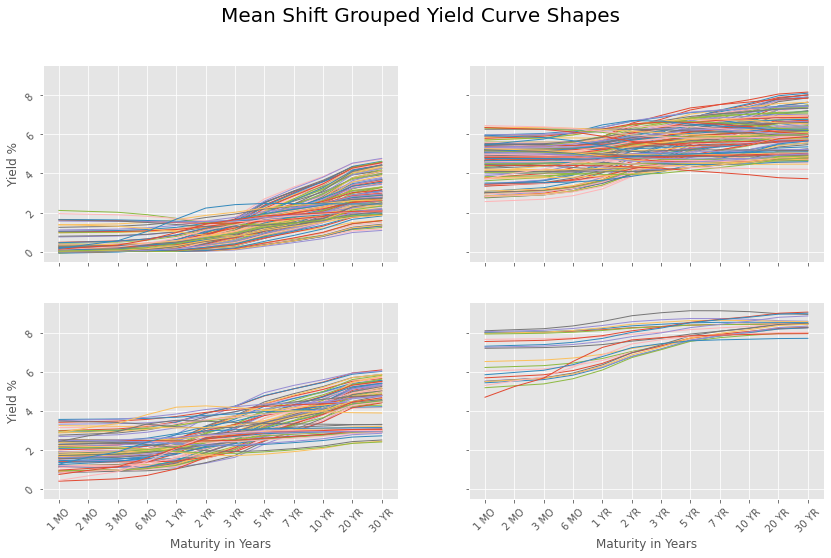

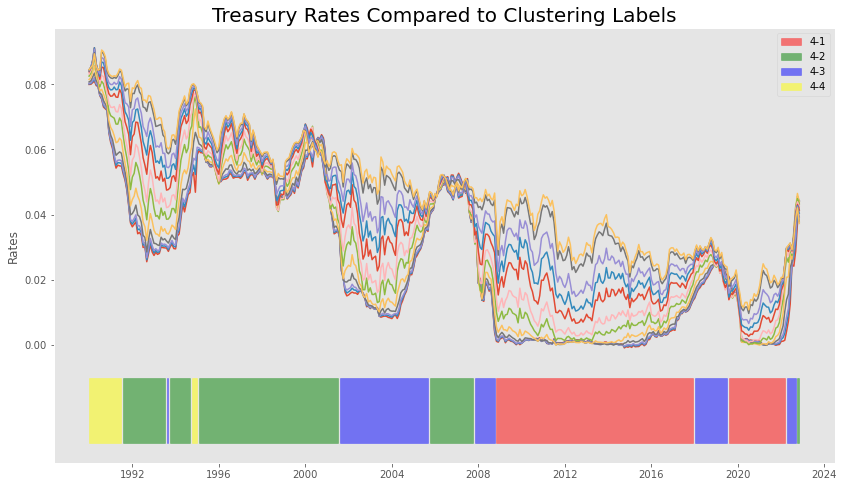

In [43]:
bw_ = 3.5858585858585856
meanshift = MeanShift(bandwidth=bw_).fit(yc)
n_clusters = len(meanshift.cluster_centers_)
print(f"Bandwith: {meanshift.bandwidth}, Clusters: {n_clusters}")

labeled = yc.copy()
labeled.loc[:,"Label"] = meanshift.predict(yc)

g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'Mean Shift Grouped Yield Curve Shapes', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

Still can't get rid of the label persistence.